In [95]:
%load_ext autoreload
%autoreload 1
import sys
import os
from pathlib import Path
sys.path.insert(1, str(Path(os.getcwd()).resolve().parent))

import pandas as pd 
pd.set_option('display.max_columns', 150)

from project.utils.data import *
%aimport project.utils.data

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA

import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (12,5)

In [4]:
df = project.utils.data.load_extended_data()

План анализа для построения авторегрессионной модели:

- МПВ анализ
- Стационарность
- Автокорреляции
- Динамика дисперсии

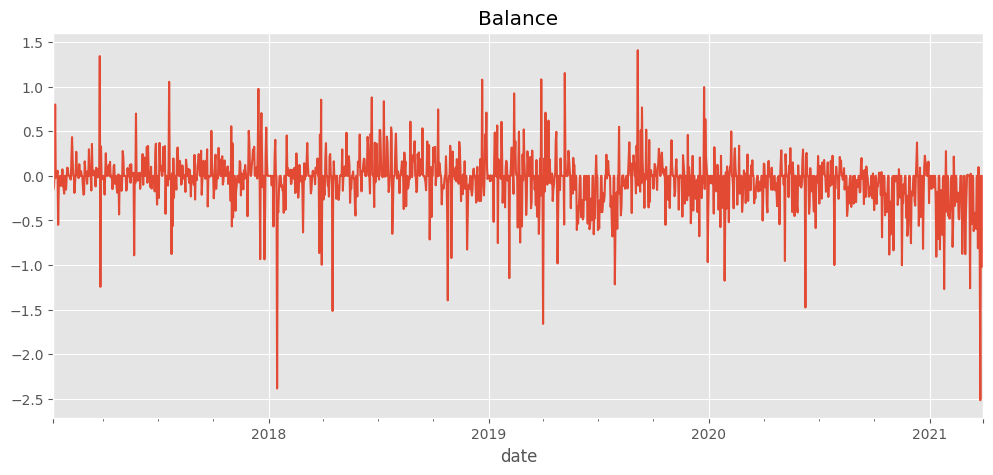

In [27]:
df.balance.plot();
plt.title('Balance');

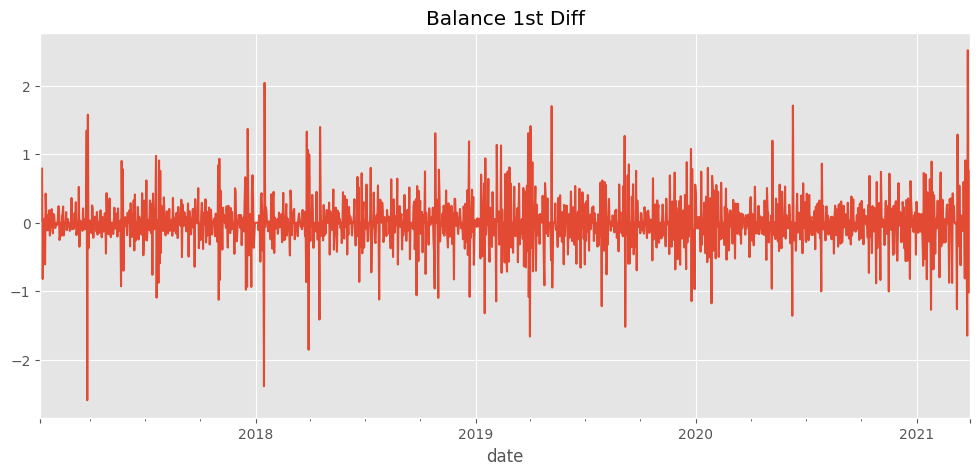

In [30]:
df.balance.diff().plot();
plt.title('Balance 1st Diff');

In [35]:
print('Balance: adf test p-value:', 
      round(
          adfuller(
              df.balance, maxlag=150, regression='c', autolag='AIC', store=False, regresults=False
          )[1],3
      )
     )

Balance: adf test p-value: 0.024


In [67]:
# print('Balance adf test for 1st difference p-value:', 
#       round(
#           adfuller(
#               df.balance.diff().dropna(), maxlag=150, regression='c', autolag='AIC', store=False, regresults=False
#           )[1],3
#       )
#      )

In [68]:
# print('Balance adf test for 2nd difference p-value:', 
#       round(
#           adfuller(
#               df.balance.diff(2).dropna(), maxlag=150, regression='c', autolag='AIC', store=False, regresults=False
#           )[1],3
#       )
#      )

Во-первых, здесь и визуальный анализ (он же Метод Пристального Взгляда) говорит нам, что ряд **выглядит довольно стационарным**, по крайней мере в широком смысле

Да еще и тест Дики-Фуллера придает нам уверенности, тк отвергаем нулевую гипотезу на большинстве разумных уровнях значимости (alpha >= 0.05)

**справка**: нулевая гипотеза теста Дики-Фуллера предполагает наличие  единичного корня, т. е. нестационарность ряда. 

А раз считаем, что ряд слабо стационарный тооо, по [теореме Вольда](https://ru.wikipedia.org/wiki/%D0%A2%D0%B5%D0%BE%D1%80%D0%B5%D0%BC%D0%B0_%D0%92%D0%BE%D0%BB%D0%B4%D0%B0) 
наш ряд должен быть представим виде $MA(\inf)$ (бесконечного скользящего среднего), который, в свою очередь, если мне не изменяет память, может быть представим в виде $ARMA(p, q)$ с конечными $p$ и $q$

А тогда, мы в общем-то имеем полное право примерить на ряд модель из класса SARIMA 

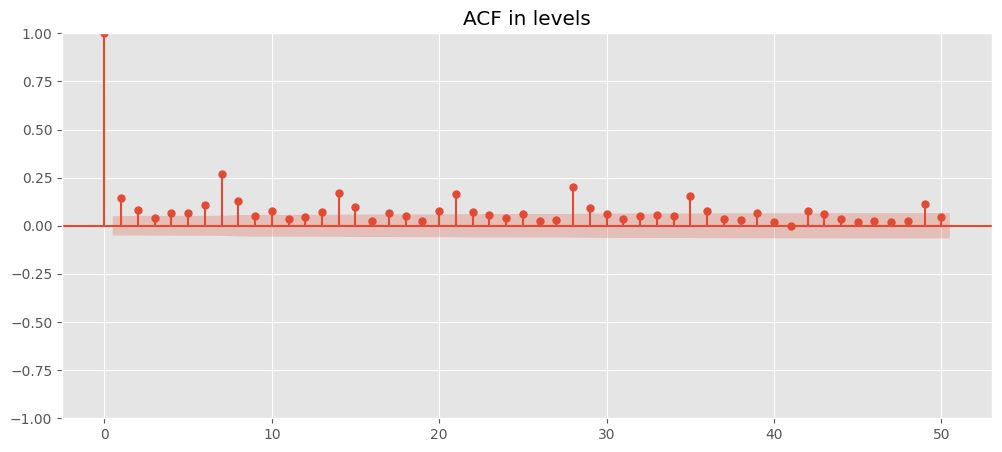

In [62]:
plot_acf(df.balance, title='ACF in levels', lags=50);

In [81]:
acf_res = acf(df.balance, nlags=50)

tr = 0.14
for index, lag in enumerate(acf_res):
    if lag > tr:
        print(index,end=' ')

0 1 7 14 21 28 35 

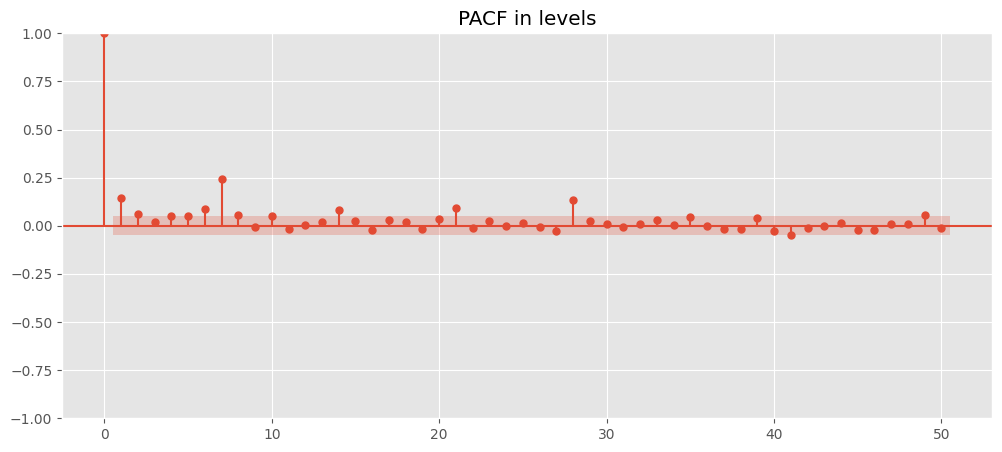

In [63]:
plot_pacf(df.balance, title='PACF in levels', lags=50);

In [80]:
pacf_res = pacf(df.balance, nlags=50)

tr = 0.1
for index, lag in enumerate(pacf_res):
    if lag > tr:
        print(index,end=' ')

0 1 7 28 

PACF отвечает за лаги самой переменной (AR-лаги), => при генерации фичей стоит включить все до 7-го. Кроме того, как можно видеть на графике ACF - есть некоторая +/- убывающая корреляция с лагами кратными семи.

Посмотрим, на сезонность

Годовая:

In [69]:
Years = df.index.year.unique()

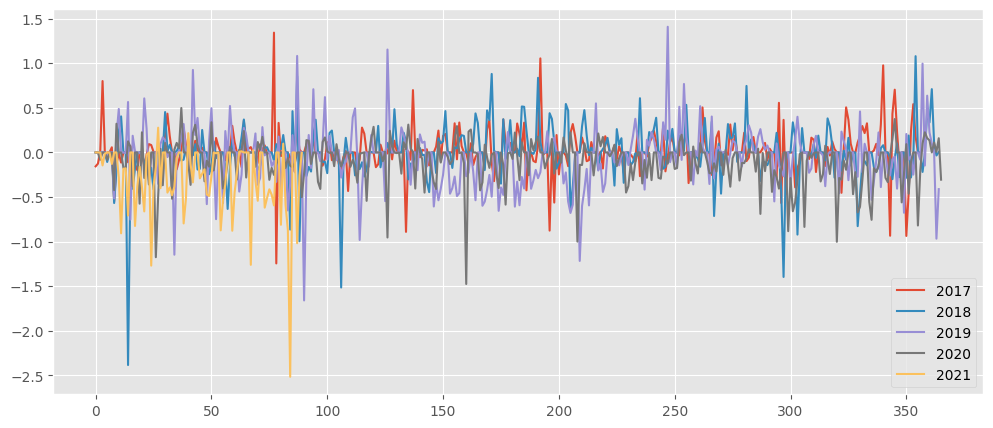

In [74]:
for i in Years:
    df[df.index.year == i].balance.reset_index(drop=True).plot(label=str(i))
plt.legend();

Месячная (судя по ACF и PACF ее нет, иначе бы был рост в районе 30-го лага), но построим график на всякий случай, как будто не жалко

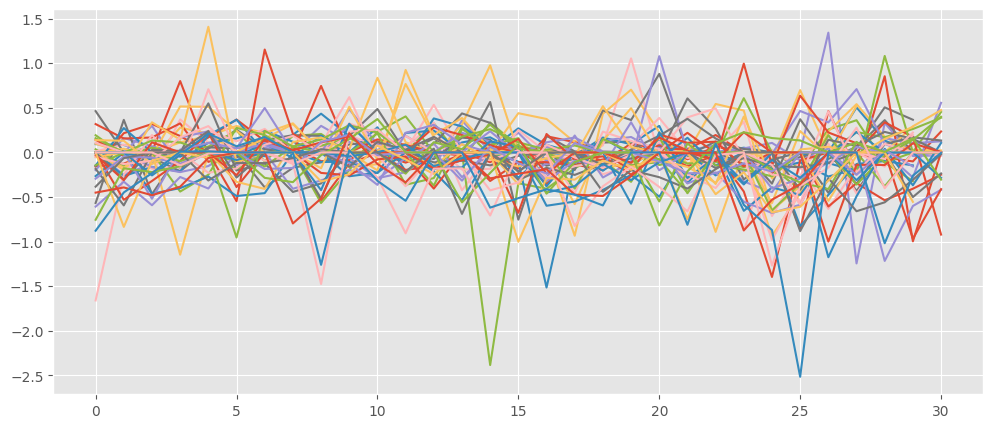

In [77]:
for i in Years:
    for j in range(1, 13):
        df[(df.index.month == j) & (df.index.year == i)].balance.reset_index(drop=True).plot(label=str(i))

Каких-то четких паттернов "большой" сезонности не выявлено

У нас кратные семи лаги повторяются в PACF, можно предположить использование недельной сезонности

Тк 1-й лаг более менее значим, можно попробовать SARIMA (P=4, 0, Q=4, s=7) (p=1, 0, q=1)

In [90]:
from sktime.forecasting.all import temporal_train_test_split

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [109]:
y_train, y_test = temporal_train_test_split(df.balance, test_size=0.1)

In [108]:
# y_train

In [100]:
weekly_seasonal = ARIMA(df.balance, order=(1, 0, 1), seasonal_order=(4, 0, 4, 7), freq='D')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [96]:
results = weekly_seasonal.fit()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [98]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                                    balance   No. Observations:                 1543
Model:             ARIMA(1, 0, 1)x(4, 0, [1, 2, 3, 4], 7)   Log Likelihood                -155.757
Date:                                    Sat, 13 Apr 2024   AIC                            335.515
Time:                                            21:13:51   BIC                            399.613
Sample:                                        01-09-2017   HQIC                           359.360
                                             - 03-31-2021                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0758      0.049     -1.541      0.123      -0.172       0.021
ar.L1          0.8746      0.075     11.628      0.000       0.727       1.022
ma.L1         -0.8178      0.088     -9.316      0.000      -0.990      -0.646
ar.S.L7       -0.0306      0.509     -0.060      0.952      -1.028       0.967
ar.S.L14       0.0920      0.056      1.649      0.099      -0.017       0.201
ar.S.L21       0.8591      0.053     16.362      0.000       0.756       0.962
ar.S.L28       0.0466      0.417      0.112      0.911      -0.771       0.865
ma.S.L7        0.1874      0.507      0.370      0.711      -0.805       1.180
ma.S.L14      -0.0273      0.036     -0.766      0.444      -0.097       0.043
ma.S.L21      -0.8803      0.036    -24.530      0.000      -0.951      -0.810
ma.S.L28      -0.1118      0.429     -0.261      0.794      -0.952       0.728
sigma2         0.0738      0.001     57.991      0.000       0.071       0.076
===================================================================================
Ljung-Box (L1) (Q):                   1.43   Jarque-Bera (JB):              7710.67
Prob(Q):                              0.23   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                            -1.08
Prob(H) (two-sided):                  0.67   Kurtosis:                        13.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

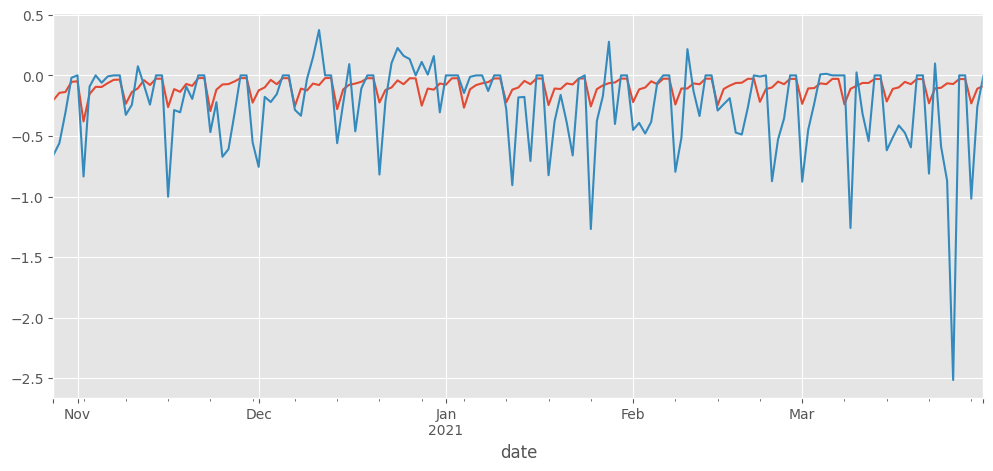

In [110]:
results.predict(start=y_test.index.min(), dynamic= True).plot()
y_test.plot();
# df[['riders', 'forecast']].plot(figsize=(12, 8))

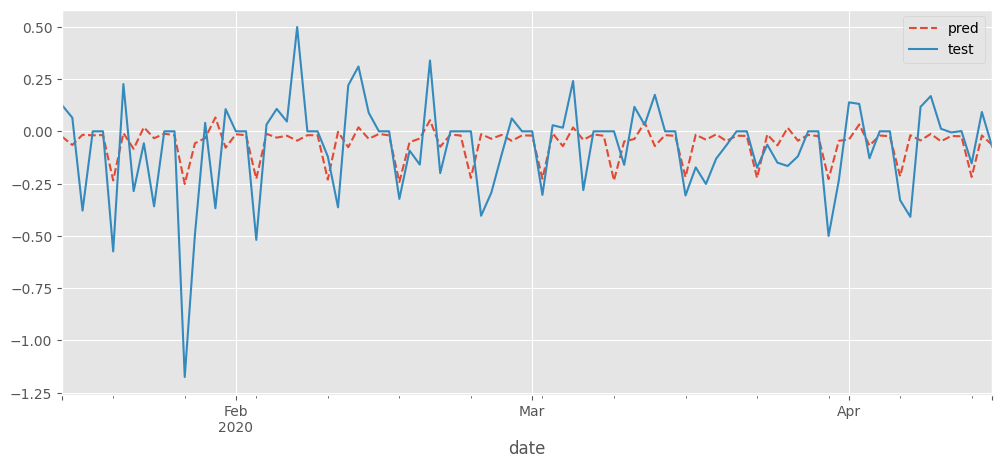

In [128]:
start = pd.Timestamp('2020-01-15')
end = pd.Timestamp('2020-04-15')

results.predict(start=start, end=end, dynamic=True).plot(label='pred', linestyle='--')
df.balance[
(df.balance.index >= start) &
(df.balance.index <= end)].plot(label='test');
plt.legend();

In [ ]:
errors = 

Так, ну как будто какие-то паттерны научились ловить, но мы сильно со

In [131]:
# df.outcome.plot();